In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from abc import abstractmethod
import torch
from torch import Tensor, nn
from torch.nn import functional as F
import math
import matplotlib.pyplot as plt
import seaborn as sns
from typing import *
import numpy as np
from collections import OrderedDict, defaultdict

In [3]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'); DEVICE
SCATTER_COEF_A = 0.0136
SCATTER_COEF_B = 0.038
X0 = {'beryllium':0.3528,  # m
      'carbon':0.1932,
      'aluminium':0.08897,
      'silicon':0.0937,
      'iron':0.01757,
      'copper':0.01436,
      'lead':0.005612,
     # 'air':312.22
     }

# Muons

## Muon generation

In [4]:
def generate_batch(n:int) -> Tensor:
    r'''
    Return tensor is (muons, coords),
    coords = (x~Uniform[0,1], y~Uniform[0,1], p=100GeV, theta_x~cos2(a) a~Uniform[0,0.5pi], theta_y~Uniform[0,2pi])
    '''
    
    batch = torch.stack([
        torch.rand(n),
        torch.rand(n),
        torch.zeros(n)+100,
        torch.clamp(torch.randn(n)/10,-math.pi/2,math.pi/2),  # Fix this
        torch.clamp(torch.randn(n)/10,-math.pi/2,math.pi/2)   # Fix this
    ], dim=1)
    return batch

In [5]:
x = generate_batch(10000)

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


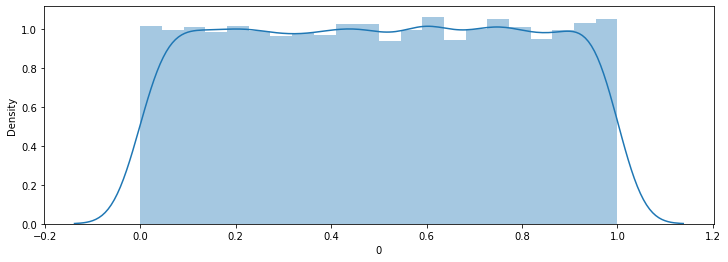

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


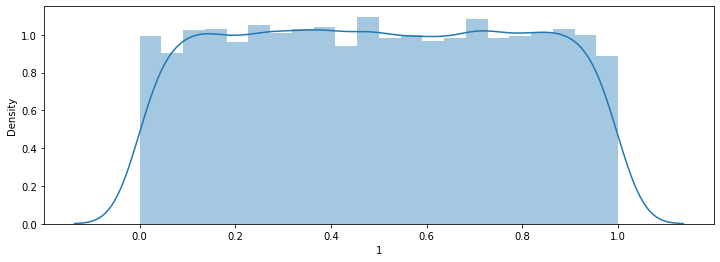

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


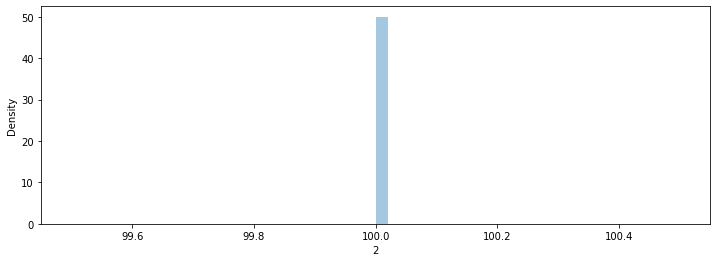

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


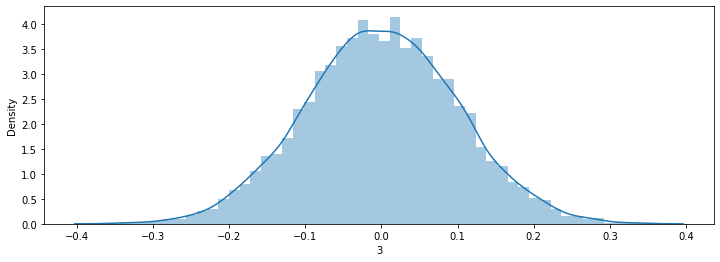

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


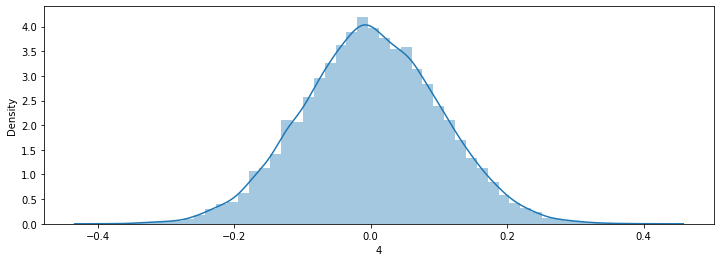

In [6]:
for i in range(x.shape[1]):
    try:
        plt.figure(figsize=(12,4))
        sns.distplot(x[:,i])
        plt.xlabel(i)
        plt.show()
    except RuntimeError:
        pass

In [7]:
m = generate_batch(100)

## Muon Batch

In [8]:
class MuonBatch:
    def __init__(self, muons:Tensor, init_z:float, device:torch.device=DEVICE):
        r'''
        coords = (0:x~Uniform[0,1], 1:y~Uniform[0,1], 2:p=100GeV, 3:theta_x~cos2(a) a~Uniform[0,0.5pi], 4:theta_y~cos2(a) a~Uniform[0,0.5pi]
        '''
        
        self.device = device
        self.muons = muons.to(self.device)
        self.z = Tensor([init_z]).to(self.device)
        self.hits = defaultdict(lambda: defaultdict(list))
        self.xy_hist = OrderedDict({})
        
    def __repr__(self) -> str:
        return f"Batch of {len(self)} muons"
        
    def __len__(self) -> int: return len(self.muons)
    
    @property
    def muons(self) -> Tensor: return self._muons
    
    @muons.setter
    def muons(self, muons:Tensor) -> None: self._muons = muons
        
    @property
    def x(self) -> Tensor: return self._muons[:,0]
    
    @x.setter
    def x(self, x:Tensor) -> None: self._muons[:,0] = x
        
    @property
    def y(self) -> Tensor: return self._muons[:,1]
    
    @y.setter
    def y(self, y:Tensor) -> None: self._muons[:,1] = y
        
    @property
    def xy(self) -> Tensor: return self._muons[:,:2]
    
    @xy.setter
    def xy(self, xy:Tensor) -> None: self._muons[:,:2] = xy
        
    @property
    def p(self) -> Tensor: return self._muons[:,2]
    
    @p.setter
    def p(self, p:Tensor) -> None: self._muons[:,2] = p
        
    @property
    def reco_p(self) -> Tensor: return self.p
    
    @reco_p.setter
    def reco_p(self, p:Tensor) -> None: raise NotImplementedError()
        
    @property
    def theta_x(self) -> Tensor: return self._muons[:,3]
    
    @theta_x.setter
    def theta_x(self, theta_x:Tensor) -> None: self._muons[:,3] = theta_x
        
    @property
    def theta_y(self) -> Tensor: return self._muons[:,4]
    
    @theta_y.setter
    def theta_y(self, theta_y:Tensor) -> None: self._muons[:,4] = theta_y
        
    @property
    def theta(self) -> Tensor: return torch.sqrt(((self.theta_x)**2)+((self.theta_y)**2))
    
    @theta.setter
    def theta(self, theta:Tensor) -> None: raise NotImplementedError()
        
    def propagate(self, dz:float) -> None:
        self.x = self.x+(dz*torch.tan(self.theta_x))
        self.y = self.y+(dz*torch.tan(self.theta_y))
        self.z -= dz
        
    def get_xy_mask(self, lw:Tensor) -> Tensor:
        return (self.x >= 0)*(self.x < lw[0])*(self.y >= 0)*(self.y < lw[1])
    
    def snapshot_xyz(self) -> None:
        self.xy_hist[self.z] = self.xy.cpu().detach().clone().numpy()
        
    def append_hits(self, hits:Dict[str,Tensor], pos:str) -> None:
        for k in hits:
            self.hits[pos][k].append(hits[k])
        
    def get_hits(self, lw:Tensor) -> Tensor:
        m = self.get_xy_mask(lw)
        return {p:{c:torch.stack(self.hits[p][c], dim=1)[m] for c in self.hits[p]} for p in self.hits}
    
    def dtheta_x(self, mu:'MuonBatch') -> Tensor:
        return torch.abs(self.theta_x-mu.theta_x)
    
    def dtheta_y(self, mu:'MuonBatch') -> Tensor:
        return torch.abs(self.theta_y-mu.theta_y)
    
    def dr(self, mu:'MuonBatch') -> Tensor:
        return torch.sqrt((self.dtheta_x(mu)**2)+(self.dtheta_y(mu)**2))
    
    def copy(self) -> 'MuonBatch':
        return MuonBatch(self._muons.detach().clone(), init_z=self.z, device=self.device)

In [9]:
batch = MuonBatch(generate_batch(1000), init_z=1)

In [10]:
batch2 = MuonBatch(generate_batch(1000), init_z=1)

In [11]:
d = batch.dtheta_x(batch2); d.min(),d.max()

(tensor(0.0002), tensor(0.4406))

In [12]:
d = batch.dr(batch2); d.min(),d.max()

(tensor(0.0097), tensor(0.5242))

In [13]:
batch.xy

tensor([[0.7608, 0.4705],
        [0.3833, 0.1674],
        [0.7781, 0.0720],
        ...,
        [0.1620, 0.5275],
        [0.2135, 0.3038],
        [0.7540, 0.6731]])

In [14]:
batch.snapshot_xyz()

In [15]:
batch.xy_hist

OrderedDict([(tensor([1.]),
              array([[0.7607984 , 0.4705339 ],
                     [0.3832683 , 0.16735274],
                     [0.7780535 , 0.07201147],
                     ...,
                     [0.16201615, 0.5274767 ],
                     [0.21346235, 0.30379897],
                     [0.75395375, 0.6731467 ]], dtype=float32))])

In [16]:
batch.propagate(0.1)

In [17]:
batch.xy

tensor([[0.7582, 0.4724],
        [0.3794, 0.1767],
        [0.7630, 0.0620],
        ...,
        [0.1708, 0.5165],
        [0.2088, 0.3198],
        [0.7607, 0.6787]])

In [18]:
batch.xy_hist

OrderedDict([(tensor([0.9000]),
              array([[0.7607984 , 0.4705339 ],
                     [0.3832683 , 0.16735274],
                     [0.7780535 , 0.07201147],
                     ...,
                     [0.16201615, 0.5274767 ],
                     [0.21346235, 0.30379897],
                     [0.75395375, 0.6731467 ]], dtype=float32))])

In [19]:
batch.snapshot_xyz()

In [20]:
batch.xy_hist

OrderedDict([(tensor([0.9000]),
              array([[0.7581656 , 0.47241175],
                     [0.3794425 , 0.17669722],
                     [0.7630324 , 0.06203146],
                     ...,
                     [0.17080846, 0.5164995 ],
                     [0.2087745 , 0.319781  ],
                     [0.7607473 , 0.6787322 ]], dtype=float32))])

# Volume+Detector

In [21]:
class Layer(nn.Module):
    def __init__(self, lw:Tensor, z:float, size:float, device:torch.device=DEVICE):
        super().__init__()
        self.lw,self.z,self.size,self.device = lw,Tensor([z]),size,device
        self.rad_length = None
        
    def scatter_and_propagate(self, mu:MuonBatch, deltaz:float) -> None:
        """
        This function produces a model of multiple scattering through a layer of material
        of depth deltaz
        
        TODO: Expand to sum over traversed voxels
        """
        
        if self.rad_length is not None:
            mask = mu.get_xy_mask(self.lw)  # Only scatter muons inside volume
            n = mask.sum()
            xy_idx = self.mu_abs2idx(mu, mask)

            x0 = self.rad_length[xy_idx[:,0],xy_idx[:,1]]*deltaz/torch.cos(mu.theta[mask])
            z1 = torch.randn(n, device=self.device)
            z2 = torch.randn(n, device=self.device)
            
            
            theta0 = (SCATTER_COEF_A/mu.p[mask]) * torch.sqrt(x0) # Ignore due to inversion problems * (1+(SCATTER_COEF_B*torch.log(x0)))
            theta_msc = math.sqrt(2) * z2 * theta0
            phi_msc = torch.rand(n, device=self.device)*2*math.pi
            dh_msc = deltaz*torch.sin(theta0)*((z1/math.sqrt(12))+(z2/2))
            dx_msc = math.sqrt(2) * dh_msc * torch.cos(phi_msc) * torch.cos(mu.theta_x[mask]) # we need to account for direction of incident particle!
            dy_msc = math.sqrt(2) * dh_msc * torch.sin(phi_msc) * torch.cos(mu.theta_y[mask]) # ... so we project onto the surface of the layer

            # Update to position at scattering. Note that if a track incides on a layer
            # with angle theta_mu, the dx and dy displacements are relative to zero angle
            # (generation of MSC formulas are oblivious of angle of incidence) so we need
            # to rescale them by cos of thetax and thetay. 
            # ---------------------------------------------------------------------------
            mu.x[mask]       = mu.x[mask] + dx_msc 
            mu.y[mask]       = mu.y[mask] + dy_msc
            mu.propagate(deltaz)
            mu.theta_x[mask] = mu.theta_x[mask] + theta_msc*torch.cos(phi_msc)
            mu.theta_y[mask] = mu.theta_y[mask] + theta_msc*torch.sin(phi_msc)
        else:
            mu.propagate(deltaz)
        
    def mu_abs2idx(self, mu:MuonBatch, mask:Optional[Tensor]=None) -> Tensor:
        xy = mu.xy
        if mask is not None: xy = xy[mask]
        return self.abs2idx(xy)
    
    def abs2idx(self, xy:Tensor) -> Tensor:
        return torch.floor(xy/self.size).long()
                         
    @abstractmethod
    def forward(self, mu:MuonBatch) -> None: pass

## Volume

In [24]:
def arb_rad_length(z:float, lw:Tensor, size:float) -> float:
    rad_length = torch.ones(list((lw/size).long()))*X0['aluminium']
    if z >= 0.3 and z <= 0.6: rad_length[3:7,3:7] = X0['lead']
#     if z == 0.6 : rad_length[...] = X0['lead']
        
    return rad_length

In [25]:
d = arb_rad_length(0.6, lw=Tensor([1,1]), size=0.1);d

tensor([[0.0890, 0.0890, 0.0890, 0.0890, 0.0890, 0.0890, 0.0890, 0.0890, 0.0890,
         0.0890],
        [0.0890, 0.0890, 0.0890, 0.0890, 0.0890, 0.0890, 0.0890, 0.0890, 0.0890,
         0.0890],
        [0.0890, 0.0890, 0.0890, 0.0890, 0.0890, 0.0890, 0.0890, 0.0890, 0.0890,
         0.0890],
        [0.0890, 0.0890, 0.0890, 0.0056, 0.0056, 0.0056, 0.0056, 0.0890, 0.0890,
         0.0890],
        [0.0890, 0.0890, 0.0890, 0.0056, 0.0056, 0.0056, 0.0056, 0.0890, 0.0890,
         0.0890],
        [0.0890, 0.0890, 0.0890, 0.0056, 0.0056, 0.0056, 0.0056, 0.0890, 0.0890,
         0.0890],
        [0.0890, 0.0890, 0.0890, 0.0056, 0.0056, 0.0056, 0.0056, 0.0890, 0.0890,
         0.0890],
        [0.0890, 0.0890, 0.0890, 0.0890, 0.0890, 0.0890, 0.0890, 0.0890, 0.0890,
         0.0890],
        [0.0890, 0.0890, 0.0890, 0.0890, 0.0890, 0.0890, 0.0890, 0.0890, 0.0890,
         0.0890],
        [0.0890, 0.0890, 0.0890, 0.0890, 0.0890, 0.0890, 0.0890, 0.0890, 0.0890,
         0.0890]])

In [26]:
x = generate_batch(10)

In [27]:
idxs = torch.floor(x[:,:2]/0.1).long()

In [28]:
d[idxs[:,0],idxs[:,1]]

tensor([0.0890, 0.0056, 0.0890, 0.0890, 0.0890, 0.0890, 0.0890, 0.0890, 0.0056,
        0.0890])

In [29]:
class PassiveLayer(Layer):
    def __init__(self, rad_length_func:Callable[[float,Tensor,float],float],
                 lw:Tensor, z:float, size:float, device:torch.device=DEVICE):
        super().__init__(lw=lw, z=z, size=size, device=device)
        self.rad_length = rad_length_func(self.z, self.lw, size=self.size).to(self.device)
                   
    def forward(self, mu:MuonBatch) -> None:
        n = 2
        for _ in range(n):
            self.scatter_and_propagate(mu, deltaz=self.size/n)

In [30]:
vl = PassiveLayer(arb_rad_length, lw=Tensor([1,1]), z=0.5, size=0.1)

In [31]:
batch = MuonBatch(generate_batch(1000), 1.0)

In [32]:
batch.xy

tensor([[0.5728, 0.0205],
        [0.0015, 0.9665],
        [0.4046, 0.6908],
        ...,
        [0.7330, 0.3971],
        [0.5026, 0.3295],
        [0.3729, 0.5131]])

In [33]:
batch.theta_x

tensor([ 4.1904e-02, -1.8676e-01, -5.6096e-02, -5.6392e-02,  1.3390e-01,
        -5.7933e-02, -1.2073e-01, -8.5018e-03, -3.9748e-02,  5.1919e-02,
         6.4004e-03,  1.3528e-01,  8.1084e-02,  1.1491e-01, -3.7092e-02,
         5.7832e-02,  5.3645e-03, -1.0074e-01,  6.3808e-02,  3.2319e-02,
        -1.6284e-02,  1.3088e-02,  1.3554e-01,  1.0039e-01,  2.8689e-02,
        -8.2582e-03, -2.6339e-02, -5.3569e-02, -3.8510e-02, -4.2578e-02,
        -1.6003e-01, -3.3601e-03, -6.0093e-02, -1.0519e-02, -4.2813e-02,
        -1.5804e-02, -9.4185e-02,  1.9884e-01,  2.6224e-02, -1.9861e-02,
         7.5289e-02, -1.7249e-02, -2.3763e-01, -1.4685e-01,  1.4498e-01,
        -7.0285e-03,  5.3583e-02,  1.9328e-01,  8.5436e-02,  9.9615e-02,
        -6.4451e-02,  9.9078e-04, -9.8703e-02,  8.0624e-02,  5.5872e-02,
        -9.0490e-02,  8.1330e-02, -5.2555e-02, -2.6667e-02, -6.4449e-02,
         5.7289e-02,  5.6002e-02, -5.6755e-02,  8.5393e-02,  7.5436e-02,
         4.4775e-02,  2.9521e-02,  1.4980e-01, -7.4

In [34]:
batch.z

tensor([1.])

In [35]:
vl(batch)

In [36]:
batch.theta_x

tensor([ 4.1907e-02, -1.8677e-01, -5.6100e-02, -5.6405e-02,  1.3390e-01,
        -5.7926e-02, -1.2073e-01, -8.5198e-03, -3.9737e-02,  5.1902e-02,
         6.3968e-03,  1.3528e-01,  8.1095e-02,  1.1486e-01, -3.7099e-02,
         5.7816e-02,  5.3591e-03, -1.0074e-01,  6.3814e-02,  3.2316e-02,
        -1.6301e-02,  1.3099e-02,  1.3554e-01,  1.0038e-01,  2.8688e-02,
        -8.2471e-03, -2.6337e-02, -5.3576e-02, -3.8491e-02, -4.2564e-02,
        -1.6004e-01, -3.3560e-03, -6.0084e-02, -1.0501e-02, -4.2812e-02,
        -1.5798e-02, -9.4188e-02,  1.9883e-01,  2.6221e-02, -1.9854e-02,
         7.5295e-02, -1.7226e-02, -2.3763e-01, -1.4685e-01,  1.4500e-01,
        -7.0049e-03,  5.3591e-02,  1.9329e-01,  8.5434e-02,  9.9623e-02,
        -6.4456e-02,  9.6874e-04, -9.8703e-02,  8.0635e-02,  5.5863e-02,
        -9.0471e-02,  8.1342e-02, -5.2567e-02, -2.6669e-02, -6.4453e-02,
         5.7277e-02,  5.6012e-02, -5.6748e-02,  8.5396e-02,  7.5426e-02,
         4.4774e-02,  2.9517e-02,  1.4980e-01, -7.4

In [37]:
batch.xy

tensor([[ 0.5770,  0.0101],
        [-0.0174,  0.9751],
        [ 0.3990,  0.6887],
        ...,
        [ 0.7397,  0.3913],
        [ 0.4957,  0.3323],
        [ 0.3609,  0.5309]])

In [38]:
batch.z

tensor([0.9000])

## Detector

### Cost functions

In [39]:
def eff_cost(x:Tensor) -> Tensor:
    return torch.expm1(3*F.relu(x))

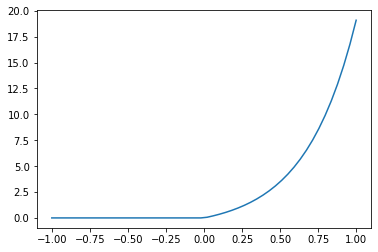

In [40]:
x = torch.linspace(-1,1,50)
plt.plot(x,eff_cost(x))

In [198]:
def res_cost(x:Tensor) -> Tensor:
    return F.relu(x/100)**2

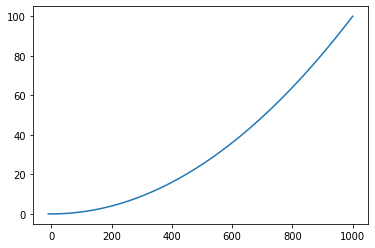

In [200]:
x = torch.linspace(-10,1000,50)
plt.plot(x,res_cost(x))

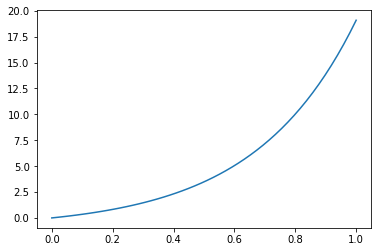

In [201]:
x = torch.linspace(0,1,50)
plt.plot(x,res_cost(x)+eff_cost(x))

### layer

In [202]:
class DetectorLayer(Layer):
    def __init__(self, pos:str, init_res:float, init_eff:float, lw:Tensor, z:float, size:float,
                 eff_cost_func:Callable[[Tensor],Tensor], res_cost_func:Callable[[Tensor],Tensor], device:torch.device=DEVICE):
        super().__init__(lw=lw, z=z, size=size, device=device)
        self.pos = pos
        self.resolution = nn.Parameter(torch.zeros(list((self.lw/size).long()), device=self.device)+init_res)
        self.efficiency = nn.Parameter(torch.zeros(list((self.lw/size).long()), device=self.device)+init_eff)
        self.eff_cost_func,self.res_cost_func = eff_cost_func,res_cost_func
        
    def get_hits(self, mu:MuonBatch) -> Dict[str,Tensor]:  # to dense and add precision
        mask = mu.get_xy_mask(self.lw)
        res,eff = torch.zeros(len(mu), device=self.device),torch.zeros(len(mu), device=self.device)  # Zero detection outside detector
        xy_idxs = self.mu_abs2idx(mu, mask)
        res[mask] = self.resolution[xy_idxs[:,0],xy_idxs[:,1]]
        eff[mask] = self.efficiency[xy_idxs[:,0],xy_idxs[:,1]]
        
        # TODO clamp deviation so that reco hit is always inside gen hit's detector element
        hits = {'xy': torch.stack([mu.x+(torch.randn(len(mu), device=self.device)/(torch.abs(res)+1e-17)),  # Inverse resolution
                                   mu.y+(torch.randn(len(mu), device=self.device)/(torch.abs(res)+1e-17))], dim=1),
                'z': self.z.expand_as(mu.x)[:,None]-(self.size/2)}
        return hits
        
    def forward(self, mu:MuonBatch) -> None:
        self.scatter_and_propagate(mu, self.size/2)
        mu.append_hits(self.get_hits(mu), self.pos)
        self.scatter_and_propagate(mu, self.size/2)
        
    def get_cost(self) -> Tensor:
        return self.eff_cost_func(self.efficiency).sum()+self.res_cost_func(self.resolution).sum()

In [203]:
batch = MuonBatch(generate_batch(1000), 1)

In [204]:
dl = DetectorLayer('above', 1,1,Tensor([1,1]),1,0.1, eff_cost_func=eff_cost, res_cost_func=res_cost)

In [205]:
dl.resolution

Parameter containing:
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], requires_grad=True)

In [206]:
dl(batch)
dl(batch)
dl(batch)

In [207]:
hits = batch.get_hits(Tensor([1,1]))

In [208]:
hits['above']['xy'].shape

torch.Size([960, 3, 2])

# Volume 

In [209]:
class Volume(nn.Module):
    def __init__(self, layers:nn.ModuleList):
        super().__init__()
        self.layers = layers
        
    def get_detectors(self) -> List[DetectorLayer]:
        return [l for l in self.layers if isinstance(l, DetectorLayer)]
    
    def get_passives(self) -> List[DetectorLayer]:
        return [l for l in self.layers if isinstance(l, PassiveLayer)]
    
    def get_rad_cube(self) -> Tensor:
        vols = reversed(self.get_passives())
        return torch.stack([v.rad_length for v in vols], dim=0)
    
    def lookup_xyz_coords(self, xyz:Tensor, passive_only:bool) -> Tensor:
        r'''Assume same size for all layers for now and no intermedeate detector layers'''
        if len(xyz.shape) == 1: xyz = xyz[None,:]
        sz = self.layers[0].size
        if passive_only: xyz[:,2] = xyz[:,2]-self.get_passives()[-1].z+sz
        return torch.floor(xyz/sz).long()
            
        
    def forward(self, mu:MuonBatch) -> None:  # Expand to take volume as input, too
        cost = None
        for l in self.layers:
            l(mu)
            mu.snapshot_xyz()
    
    def get_cost(self) -> Tensor:
        cost = None
        for l in self.layers:
            if hasattr(l, 'get_cost'):
                if cost is None:
                    cost = l.get_cost()
                else:
                    cost = cost+l.get_cost()
                return cost
    
    @property
    def lw(self) -> Tensor: return self.layers[-1].lw
    
    @property
    def size(self) -> float: return self.layers[-1].size  # Same size for each layer
    
    @property
    def h(self) -> float: return len(self.layers)*self.layers[-1].size  # Same size for each layer
    
    def get_passive_z_range(self) -> Tuple[Tensor,Tensor]:
        ps = self.get_passives()
        return ps[-1].z-self.size,ps[0].z

In [210]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.5
    init_res = 10000
    pos = 'above'
    for z,d in zip(np.arange(lwh[2],0,-size), [1,1,0,0,0,0,0,0,1,1]):
        if d:
            layers.append(DetectorLayer(pos=pos, init_eff=init_eff, init_res=init_res,
                                        lw=lwh[:2], z=z, size=size, eff_cost_func=eff_cost, res_cost_func=res_cost))
        else:
            pos = 'below'
            layers.append(PassiveLayer(rad_length_func=arb_rad_length, lw=lwh[:2], z=z, size=size))

    return nn.ModuleList(layers) 

In [211]:
layers = get_layers()

In [212]:
volume = Volume(layers=layers); volume

Volume(
  (layers): ModuleList(
    (0): DetectorLayer()
    (1): DetectorLayer()
    (2): PassiveLayer()
    (3): PassiveLayer()
    (4): PassiveLayer()
    (5): PassiveLayer()
    (6): PassiveLayer()
    (7): PassiveLayer()
    (8): DetectorLayer()
    (9): DetectorLayer()
  )
)

In [213]:
volume.lw, volume.size, volume.h, volume.get_passive_z_range()

(tensor([1., 1.]), 0.1, 1.0, (tensor([0.2000]), tensor([0.8000])))

In [214]:
batch = MuonBatch(generate_batch(1000), init_z=1)

In [215]:
volume(batch)

In [216]:
hits = batch.get_hits(Tensor([1,1]))

In [217]:
hits['above']['xy'].shape

torch.Size([841, 2, 2])

In [218]:
volume.get_rad_cube().shape

torch.Size([6, 10, 10])

# Atomic number reco

## Compute deviations and scatter locations

In [219]:
def jacobian(y:Tensor, x:Tensor, create_graph=False, allow_unused=True):
    r'''Compute full jacobian matrix for single tensor. Call twice for hessian.
    Copied from https://gist.github.com/apaszke/226abdf867c4e9d6698bd198f3b45fb7 credits: Adam Paszke
    TODO: Fix this to work batch-wise (maybe https://gist.github.com/sbarratt/37356c46ad1350d4c30aefbd488a4faa)'''
    jac = []
    flat_y = y.reshape(-1)
    grad_y = torch.zeros_like(flat_y)
    for i in range(len(flat_y)):
        grad_y[i] = 1.  # may need to use value of flat_y?
        grad_x, = torch.autograd.grad(flat_y, x, grad_y, retain_graph=True, create_graph=create_graph, allow_unused=allow_unused)
        jac.append(grad_x.reshape(x.shape))
        grad_y[i] = 0.
    return torch.stack(jac).reshape(y.shape + x.shape)

In [220]:
layers

ModuleList(
  (0): DetectorLayer()
  (1): DetectorLayer()
  (2): PassiveLayer()
  (3): PassiveLayer()
  (4): PassiveLayer()
  (5): PassiveLayer()
  (6): PassiveLayer()
  (7): PassiveLayer()
  (8): DetectorLayer()
  (9): DetectorLayer()
)

In [221]:
class ScatterBatch:
    def __init__(self, mu:MuonBatch, volume:Volume):
        self.mu,self.volume = mu,volume
        self.hits = self.mu.get_hits(self.volume.lw)
        self.compute_scatters()

    def compute_scatters(self) -> None:
        r'''
        Currently only handles 2 detectors above and below passive volume
        
        Scatter locations adapted from:
        @MISC {3334866,
            TITLE = {Closest points between two lines},
            AUTHOR = {Brian (https://math.stackexchange.com/users/72614/brian)},
            HOWPUBLISHED = {Mathematics Stack Exchange},
            NOTE = {URL:https://math.stackexchange.com/q/3334866 (version: 2019-08-26)},
            EPRINT = {https://math.stackexchange.com/q/3334866},
            URL = {https://math.stackexchange.com/q/3334866}
        }
        '''

        # self.hits in layers
        xa0 = torch.cat([self.hits['above']['xy'][:,0], self.hits['above']['z'][:,0]], dim=-1) # reco x, reco y, gen z, res
        xa1 = torch.cat([self.hits['above']['xy'][:,1], self.hits['above']['z'][:,1]], dim=-1) 
        xb0 = torch.cat([self.hits['below']['xy'][:,1], self.hits['below']['z'][:,1]], dim=-1) 
        xb1 = torch.cat([self.hits['below']['xy'][:,0], self.hits['below']['z'][:,0]], dim=-1)

        dets = self.volume.get_detectors()
        res = []
        for p,l,i in zip(('above','above','below','below'),dets,(0,1,0,1)):
            x = l.abs2idx(self.hits[p]['xy'][:,i])
            res.append(l.resolution[x[:,0],x[:,1]])
        res2 = torch.stack(res, dim=1)[:,:,None]**2

        # Extrapolate muon-path vectors from self.hits
        v1 = xa1-xa0  
        v2 = xb1-xb0

        # scatter locations
        v3 = torch.cross(v1, v2, dim=1)  # connecting vector perpendicular to both lines
        rhs = xb0-xa0
        lhs = torch.stack([v1, -v2, v3], dim=1).transpose(2,1)
        coefs = torch.linalg.solve(lhs, rhs)  # solve p1+t1*v1 + t3*v3 = p2+t2*v2 => p2-p1 = t1*v1 - t2*v2 + t3*v3

        q1 = xa0+(coefs[:,0:1]*v1)  # closest point on v1
        self._loc = q1+(coefs[:,2:3]*v3/2)  # Move halfway along v3 from q1

        # Theta deviations
        self._theta_in = v1[:,2:3]*torch.arctan(v1[:,:2])
        self._theta_out = v2[:,2:3]*torch.arctan(v2[:,:2])
        self._dtheta = torch.abs(self._theta_in-self._theta_out)

        # xy deviations
        self._dxy = coefs[:,2:3]*v3[:,:2]

        # loc uncertainty
        dloc_dres = torch.stack([jacobian(self._loc, l.resolution).sum((-1,-2)) for l in dets], dim=1)
        self._loc_unc = torch.sqrt((dloc_dres.pow(2)*res2).sum(1))

        # dtheta uncertainty
        ddtheta_dres = torch.stack([jacobian(self._dtheta, l.resolution).sum((-1,-2)) for l in dets], dim=1)
        self._dtheta_unc = torch.sqrt((ddtheta_dres.pow(2)*res2).sum(1))

        # dxy uncertainty
        ddxy_dres = torch.stack([jacobian(self._dxy, l.resolution).sum((-1,-2)) for l in dets], dim=1)
        self._dxy_unc = torch.sqrt((ddxy_dres.pow(2)*res2).sum(1))

        # theta_in uncertainty
        dtheta_in_dres = torch.stack([jacobian(self._theta_in, l.resolution).sum((-1,-2)) for l in dets[:2]], dim=1)
        self._theta_in_unc = torch.sqrt((dtheta_in_dres.pow(2)*res2[:,:2]).sum(1))

        # theta_out uncertainty
        dtheta_out_dres = torch.stack([jacobian(self._theta_out, l.resolution).sum((-1,-2)) for l in dets[2:]], dim=1)
        self._theta_out_unc = torch.sqrt((dtheta_out_dres.pow(2)*res2[:,2:]).sum(1))
        
    @property
    def location(self) -> Tensor: return self._loc
    
    @property
    def location_unc(self) -> Tensor: return self._loc_unc
    
    @property
    def dtheta(self) -> Tensor: return self._dtheta
    
    @property
    def dtheta_unc(self) -> Tensor: return self._dtheta_unc
    
    @property
    def dxy(self) -> Tensor: return self._dxy
    
    @property
    def dxy_unc(self) -> Tensor: return self._dxy_unc
    
    @property
    def theta_out(self) -> Tensor: return self._theta_out
    
    @property
    def theta_out_unc(self) -> Tensor: return self._theta_out_unc
    
    @property
    def theta_in(self) -> Tensor: return self._theta_in
    
    @property
    def theta_in_unc(self) -> Tensor: return self._theta_in_unc
    
    def plot_scatter(self, idx:int) -> None:
        x = np.hstack([self.hits['above']['xy'][idx,:,0].detach().cpu().numpy(),self.hits['below']['xy'][idx,:,0].detach().cpu().numpy()])
        y = np.hstack([self.hits['above']['xy'][idx,:,1].detach().cpu().numpy(),self.hits['below']['xy'][idx,:,1].detach().cpu().numpy()])
        z = np.hstack([self.hits['above']['z'][idx,:,0].detach().cpu().numpy(),self.hits['below']['z'][idx,:,0].detach().cpu().numpy()])
        scatter = self.location[idx].detach().cpu().numpy()
        fig,axs = plt.subplots(1,2, figsize=(8,4))
        axs[0].scatter(x,z)
        axs[0].scatter(scatter[0], scatter[2])
        axs[0].set_xlim(0,1)
        axs[0].set_xlabel('x')
        axs[0].set_ylabel('z')
        axs[1].scatter(y,z)
        axs[1].scatter(scatter[1], scatter[2])
        axs[1].set_xlim(0,1)
        axs[1].set_xlabel('y')
        axs[1].set_ylabel('z')
        plt.show
        
    def get_scatter_mask(self) -> Tensor:
        z = self.volume.get_passive_z_range()
        return (self.location[:,2] >= z[0])*(self.location[:,2] < z[1])

In [222]:
scatters = ScatterBatch(batch, volume)

In [223]:
scatters.location

tensor([[0.4855, 0.5543, 0.3393],
        [0.1999, 0.7566, 0.3401],
        [0.4004, 0.4580, 0.3648],
        ...,
        [0.4997, 0.7759, 1.4600],
        [0.3045, 0.2144, 0.5249],
        [0.6248, 0.8024, 0.2447]], grad_fn=<AddBackward0>)

In [224]:
scatters.location_unc

tensor([[0.0165, 0.0163, 0.4715],
        [0.0231, 0.0077, 0.2481],
        [0.0966, 0.0580, 1.6768],
        ...,
        [0.4581, 0.2436, 3.2530],
        [0.0333, 0.0816, 0.5430],
        [0.0212, 0.0341, 0.1944]], grad_fn=<SqrtBackward>)

In [225]:
scatters.dtheta

tensor([[9.8466e-06, 1.5557e-05],
        [2.2305e-06, 1.8120e-05],
        [4.3213e-07, 1.7795e-05],
        ...,
        [4.3801e-06, 2.6820e-06],
        [1.9269e-05, 8.6050e-06],
        [3.1730e-05, 6.0837e-06]], grad_fn=<AbsBackward>)

In [226]:
scatters.dtheta_unc

tensor([[2.2351e-05, 1.1319e-05],
        [1.2764e-05, 2.0456e-05],
        [2.5188e-05, 2.0354e-05],
        ...,
        [1.3666e-05, 7.0568e-06],
        [2.0589e-05, 1.7612e-05],
        [1.8880e-05, 1.8706e-05]], grad_fn=<SqrtBackward>)

In [227]:
scatters.dxy

tensor([[-5.7413e-04,  3.6340e-04],
        [-4.0104e-06, -4.9373e-07],
        [ 1.8801e-03, -4.5657e-05],
        ...,
        [ 2.1126e-04,  3.4506e-04],
        [-2.8039e-04,  6.2776e-04],
        [ 9.2188e-05, -4.8072e-04]], grad_fn=<MulBackward0>)

In [228]:
scatters.dxy_unc

tensor([[7.3437e-04, 6.2346e-04],
        [4.3534e-04, 5.4268e-05],
        [1.0338e-03, 2.6434e-03],
        ...,
        [6.4238e-04, 2.8035e-04],
        [3.7777e-04, 1.0302e-03],
        [1.6538e-04, 9.5817e-04]], grad_fn=<SqrtBackward>)

In [229]:
scatters.theta_in

tensor([[-0.0004,  0.0003],
        [ 0.0009, -0.0003],
        [ 0.0006,  0.0003],
        ...,
        [ 0.0014, -0.0007],
        [ 0.0006,  0.0015],
        [ 0.0011, -0.0017]], grad_fn=<MulBackward0>)

In [230]:
scatters.theta_in_unc

tensor([[1.0957e-05, 1.1399e-06],
        [6.9578e-06, 3.7334e-06],
        [1.7988e-05, 1.2166e-05],
        ...,
        [8.4637e-06, 4.2156e-07],
        [1.5462e-05, 8.0509e-06],
        [8.1210e-06, 1.5300e-05]], grad_fn=<SqrtBackward>)

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.48796263

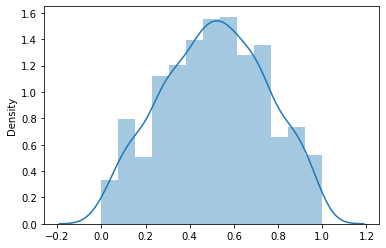

In [231]:
z = scatters.location[:,2].cpu().detach().numpy()
m = (z>0)*(z<1)
sns.distplot(z[m])
z.mean()

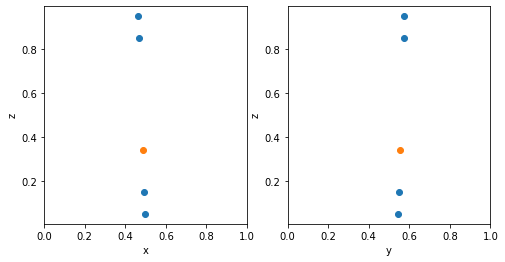

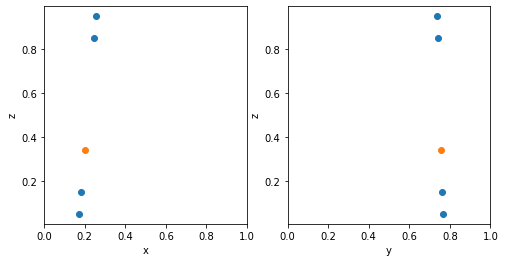

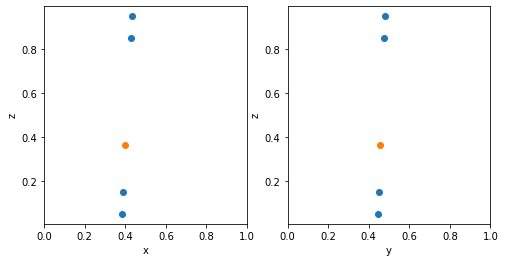

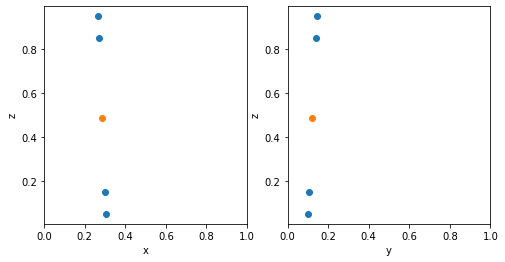

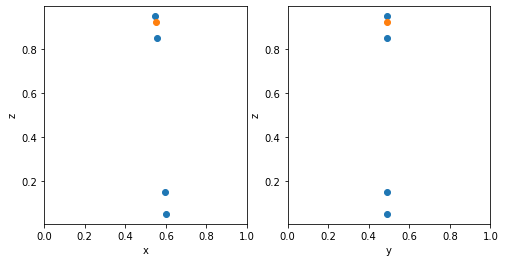

In [232]:
for i in range(5): scatters.plot_scatter(i)

## Infer rad length

### Preds per muon

In [233]:
class X0Inferer:
    def __init__(self, scatters:ScatterBatch, mu:MuonBatch, default_pred:float=X0['beryllium']):
        self.scatters,self.mu,self.default_pred = scatters,mu,default_pred
        self.volume,self.hits = self.scatters.volume,self.scatters.hits
        self.size,self.lw = self.volume.size,self.volume.lw
        
    def x0_from_dtheta(self) -> Tuple[Tensor,Tensor]:
        r'''
        TODO: Debias by considering each voxel on muon paths
        '''
        
        p = self.mu.reco_p[batch.get_xy_mask(self.lw)][self.mask]
        dtheta = self.scatters.dtheta[self.mask]
        dtheta_unc = self.scatters.dtheta_unc[self.mask]
        theta_xy_in = self.scatters.theta_in[self.mask]
        theta_xy_out = self.scatters.theta_out[self.mask]
        theta_xy_in_unc = self.scatters.theta_in_unc[self.mask]
        theta_xy_out_unc = self.scatters.theta_out_unc[self.mask]

        # Prediction
        theta2 = dtheta.pow(2).sum(1)
        n_x0 = 0.5*theta2*((p/SCATTER_COEF_A)**2)
        theta_in = theta_xy_in.pow(2).sum(1).sqrt()
        theta_out = theta_xy_out.pow(2).sum(1).sqrt()
        cos_theta_in = torch.cos(theta_in)
        cos_theta_out = torch.cos(theta_out)
        cos_sum = cos_theta_in+cos_theta_out
        pred = n_x0*cos_sum/(0.5*self.size)
        
        # Uncertainty
        theta2_unc = (2*dtheta*dtheta_unc).pow(2).sum(1).sqrt()
        n_x0_unc = 0.5*theta2_unc*((p/SCATTER_COEF_A)**2)
        theta_in2_unc = (2*theta_xy_in*theta_xy_in_unc).pow(2).sum(1).sqrt()
        theta_in_unc = 0.5*theta_in2_unc/theta_in
        theta_out2_unc = (2*theta_xy_out*theta_xy_out_unc).pow(2).sum(1).sqrt()
        theta_out_unc = 0.5*theta_out2_unc/theta_out
        cos_theta_in_unc = torch.sin(theta_in)*theta_in_unc
        cos_theta_out_unc = torch.sin(theta_out)*theta_out_unc
        cos_sum_unc = torch.sqrt(cos_theta_in_unc.pow(2)+cos_theta_out_unc.pow(2))
        pred_unc = pred*torch.sqrt((n_x0_unc/n_x0).pow(2)+(cos_sum_unc/cos_sum).pow(2))
        
        return pred,pred_unc
    
    def x0_from_dxy(self) -> Tuple[Tensor,Tensor]:
        # TODO: FIX this
#         dxy = torch.sqrt(scatters['dxy'][mask].pow(2).sum(1))
#         dh = dxy/((math.sqrt(2)*torch.cos(scatters['theta_in'][mask].pow(2).sum(1)))+1e-17)
#         theta0 = torch.arcsin(dh/self.size)
#         x0_pred_dxy = (theta0*p/b)**2
        return None,None

    def compute_efficiency(self) -> Tensor:
        eff = None
        for p,l,i in zip(('above','above','below','below'),self.volume.get_detectors(),(0,1,0,1)):
            x = l.abs2idx(self.hits[p]['xy'][:,i][self.mask])
            e = l.efficiency[x[:,0],x[:,1]]
            if eff is None: eff = e
            else:           eff = eff*e
        return eff
    
    def average_preds(self, x0_dtheta:Optional[Tensor], x0_dtheta_unc:Optional[Tensor], x0_dxy:Optional[Tensor], x0_dxy_unc:Optional[Tensor], efficiency:Tensor) -> Tensor:
        loc,loc_unc = self.scatters.location[self.mask],self.scatters.location_unc[self.mask]
        loc_idx = self.volume.lookup_xyz_coords(loc, passive_only=True)
        idxs = torch.arange(len(loc)).long(),loc_idx[:,2],loc_idx[:,0],loc_idx[:,1]
        
        pred,weight = [],[]
        for x0,unc in ((x0_dtheta,x0_dtheta_unc),(x0_dxy,x0_dxy_unc)):
            if x0 is None: continue
            w = nn.init.zeros_(self.volume.get_rad_cube())
            w = torch.repeat_interleave(w[None,:], len(loc), dim=0)
            w[idxs] = efficiency/((1e-17)+(unc**2))
            
            p = w.clone()
            p[idxs] = x0*p[idxs]
            pred.append(p)
            weight.append(w)
            
        pred,weight = torch.cat(pred, dim=0),torch.cat(weight, dim=0)
        pred,weight = pred.sum(0),weight.sum(0)
        pred = pred/weight
        return pred,weight
    
    def add_default_pred(self, pred:Tensor, weight:Tensor) -> None:
        m = pred != pred
        pred[m] = self.default_pred
        weight[m] = 1/(self.default_pred**2)
        
    def pred_x0(self) -> Tuple[Tensor,Tensor]:
        self.mask = self.scatters.get_scatter_mask()
        x0_dtheta,x0_dtheta_unc = self.x0_from_dtheta()
        x0_dxy,x0_dxy_unc = self.x0_from_dxy()
        eff = self.compute_efficiency()
        
        pred,weight = self.average_preds(x0_dtheta=x0_dtheta, x0_dtheta_unc=x0_dtheta_unc, x0_dxy=x0_dxy, x0_dxy_unc=x0_dxy_unc, efficiency=eff)
        self.add_default_pred(pred,weight)
        return pred,weight

In [234]:
x0_inferer = X0Inferer(scatters, batch)

In [235]:
pred,weight = x0_inferer.pred_x0()

In [236]:
pred

tensor([[[0.3528, 1.0623, 0.3528, 0.3528, 0.6334, 0.1481, 0.3528, 0.3528,
          1.8278, 0.3528],
         [0.3528, 0.6492, 0.4246, 0.1801, 0.3528, 0.1367, 0.2326, 0.9428,
          0.3528, 0.2441],
         [1.3692, 0.3528, 0.1530, 0.3528, 0.3528, 1.0023, 0.3528, 0.3859,
          0.3528, 0.3528],
         [0.1217, 0.7449, 0.3528, 0.3528, 0.3528, 0.3528, 0.6049, 0.3528,
          0.3528, 1.6820],
         [0.1768, 0.3528, 0.4783, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528,
          0.8389, 0.6494],
         [1.3263, 1.4561, 0.3528, 0.3528, 0.3528, 0.5665, 0.1045, 0.3528,
          0.3528, 0.3528],
         [0.1857, 0.3528, 0.3528, 1.1833, 0.3528, 0.6042, 0.1911, 0.3528,
          1.1287, 0.2222],
         [0.1034, 0.3528, 1.2107, 0.3528, 0.3528, 0.3528, 0.5460, 1.1290,
          0.3528, 0.3528],
         [0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 1.1456, 0.3528, 0.3355,
          1.2875, 0.3528],
         [0.8510, 0.3528, 0.7253, 0.3528, 1.5684, 0.3528, 0.3528, 0.2589,
          1.2017,

In [237]:
X0['aluminium'], X0['lead'], X0['beryllium']

(0.08897, 0.005612, 0.3528)

# Loss

In [238]:
rad_true = volume.get_rad_cube()

In [239]:
mfse = (pred-rad_true).pow(2).mean()  # weights is inverse variance
mfse

tensor(1.1870, grad_fn=<MeanBackward0>)

In [240]:
pred

tensor([[[0.3528, 1.0623, 0.3528, 0.3528, 0.6334, 0.1481, 0.3528, 0.3528,
          1.8278, 0.3528],
         [0.3528, 0.6492, 0.4246, 0.1801, 0.3528, 0.1367, 0.2326, 0.9428,
          0.3528, 0.2441],
         [1.3692, 0.3528, 0.1530, 0.3528, 0.3528, 1.0023, 0.3528, 0.3859,
          0.3528, 0.3528],
         [0.1217, 0.7449, 0.3528, 0.3528, 0.3528, 0.3528, 0.6049, 0.3528,
          0.3528, 1.6820],
         [0.1768, 0.3528, 0.4783, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528,
          0.8389, 0.6494],
         [1.3263, 1.4561, 0.3528, 0.3528, 0.3528, 0.5665, 0.1045, 0.3528,
          0.3528, 0.3528],
         [0.1857, 0.3528, 0.3528, 1.1833, 0.3528, 0.6042, 0.1911, 0.3528,
          1.1287, 0.2222],
         [0.1034, 0.3528, 1.2107, 0.3528, 0.3528, 0.3528, 0.5460, 1.1290,
          0.3528, 0.3528],
         [0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 1.1456, 0.3528, 0.3355,
          1.2875, 0.3528],
         [0.8510, 0.3528, 0.7253, 0.3528, 1.5684, 0.3528, 0.3528, 0.2589,
          1.2017,

In [241]:
class DetectorLoss(nn.MSELoss):
    def __init__(self, cost_coef:float):
        super().__init__()
        self.cost_coef = cost_coef        
        
    def forward(self, pred_x0:Tensor, volume:Volume) -> Tensor:
        return super().forward(pred_x0, volume.get_rad_cube())+(self.cost_coef*volume.get_cost())

In [249]:
loss = DetectorLoss(1e-6)

In [250]:
loss(pred, volume)

tensor(2.1874, grad_fn=<AddBackward0>)

In [251]:
volume.get_cost()

tensor(1000348.1875, grad_fn=<AddBackward0>)